# [Visual Crossing Weather](https://www.visualcrossing.com)

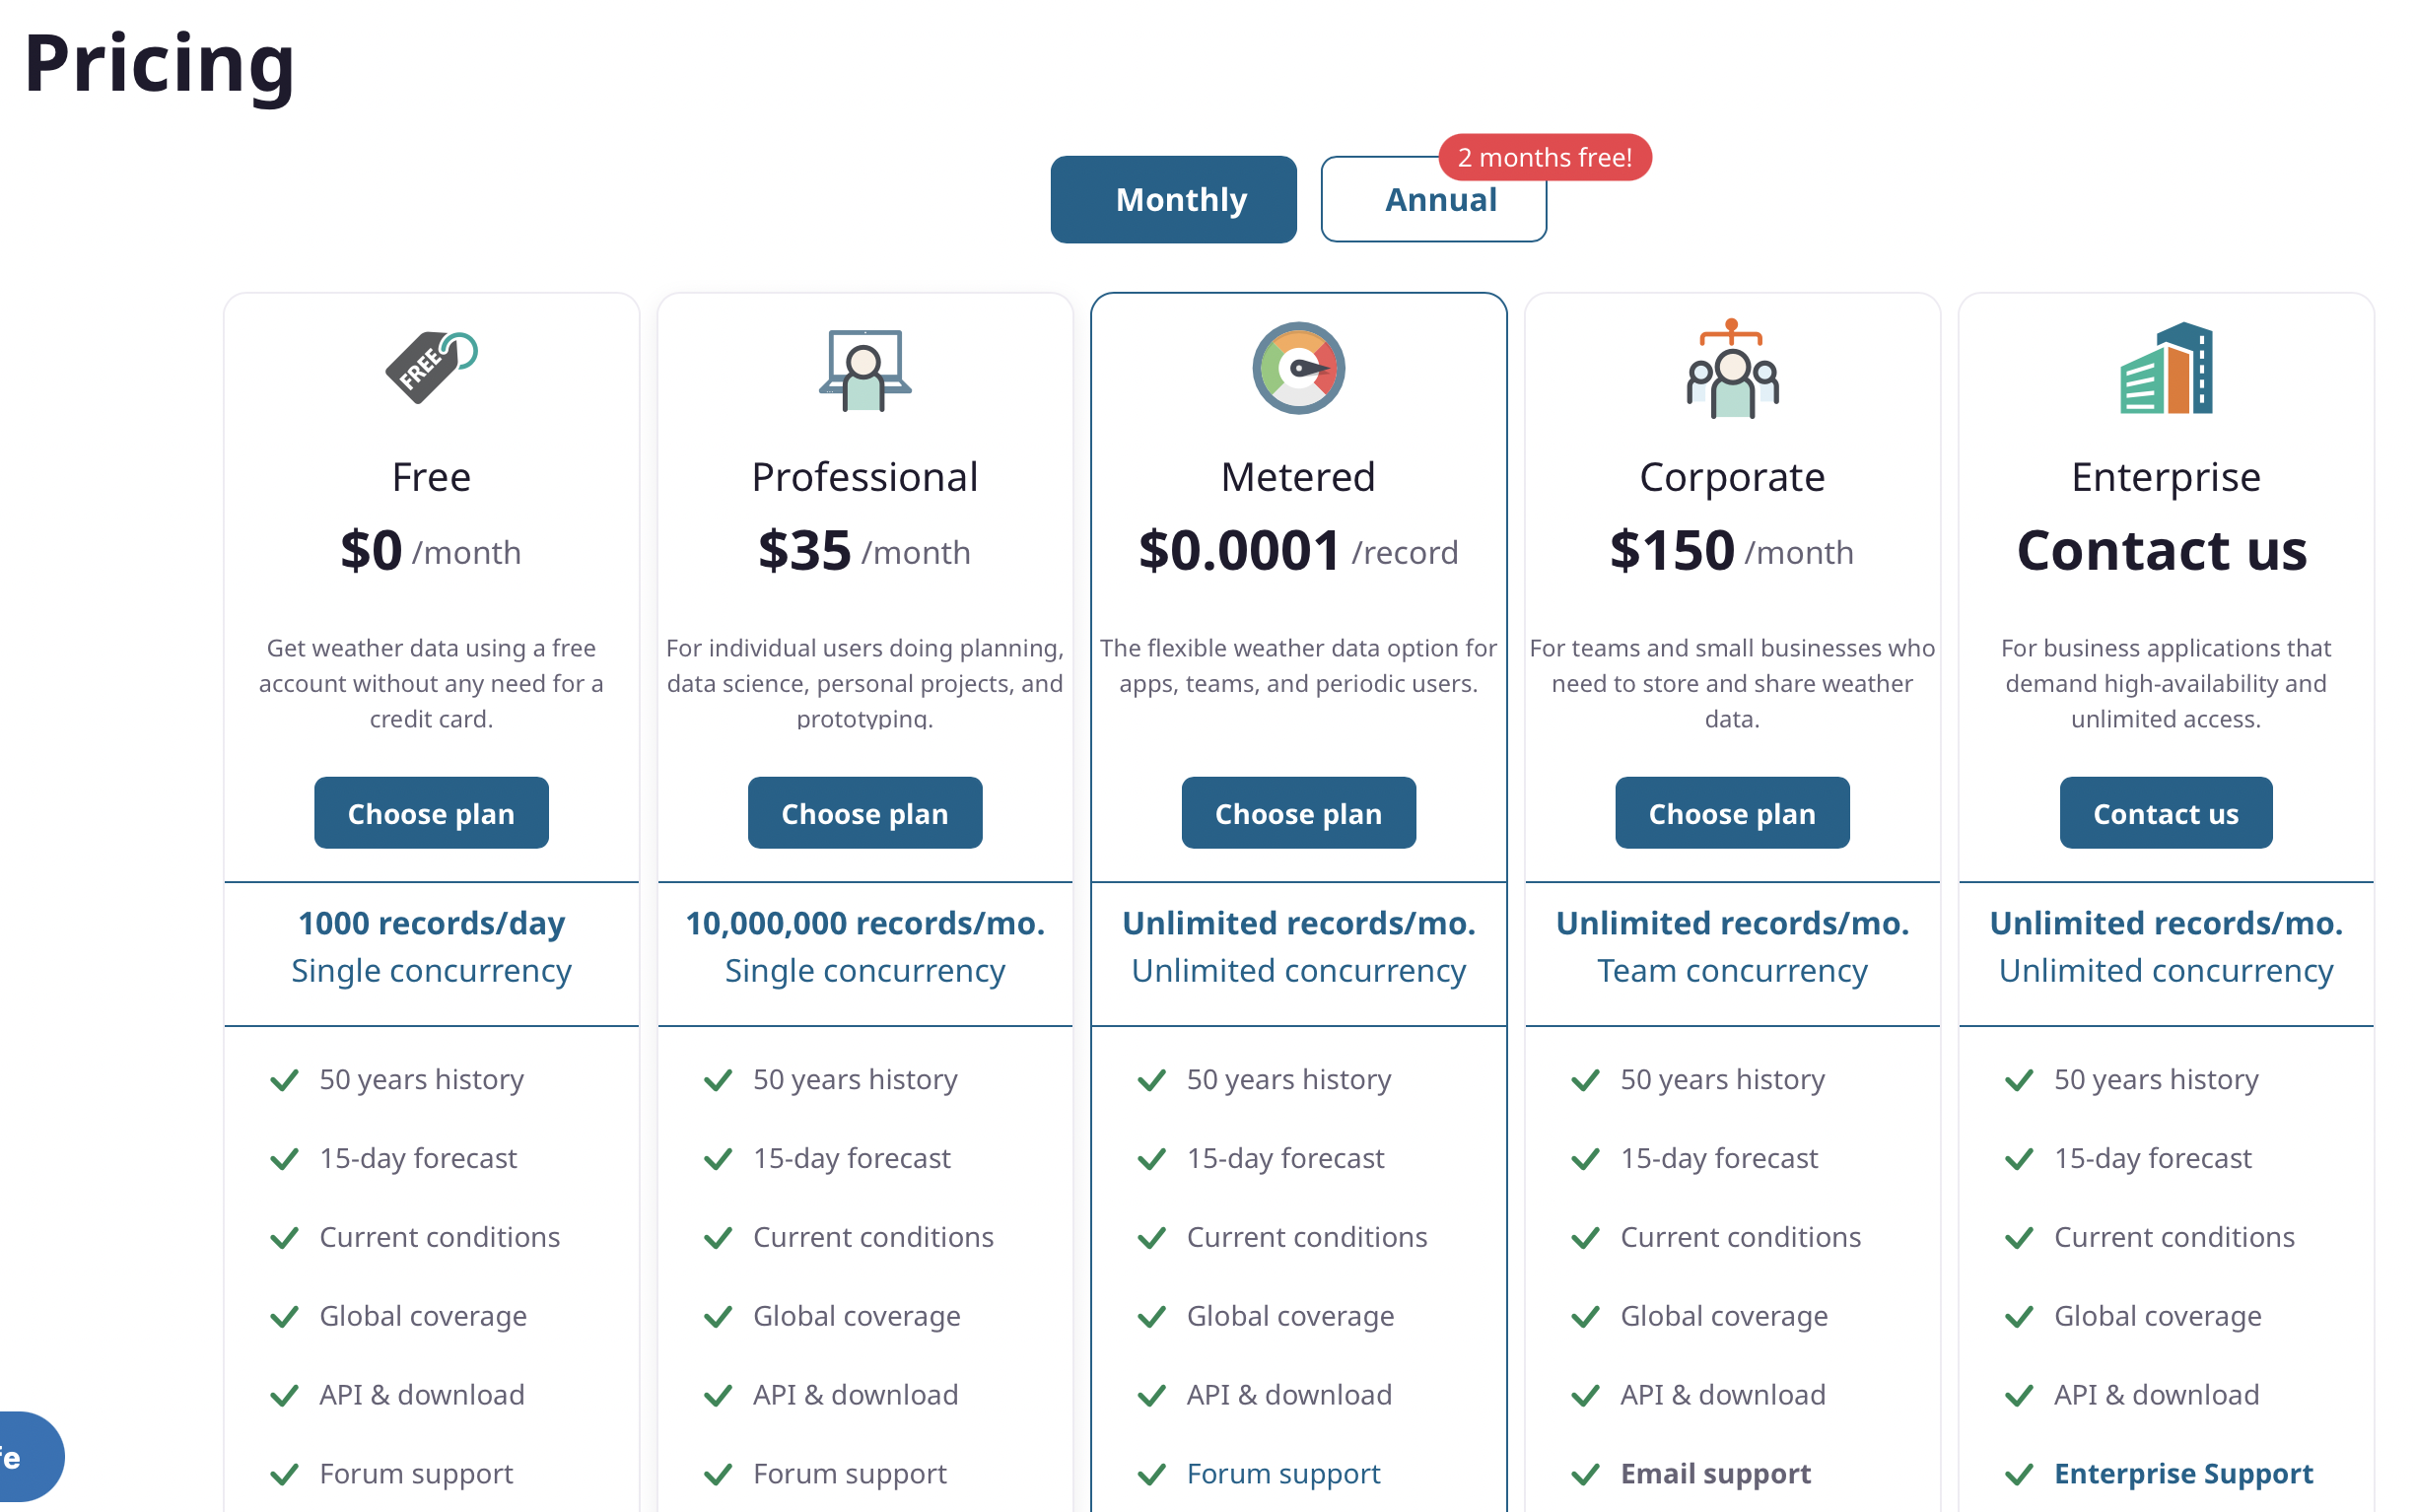

#### I found this site for gathering weather data. It seems perfect for my usecase since I do not need that detailed data (like hourly is enough).
#### Best thing is I can send an api request for the weather data using __lattitude__ and __longitude__ which is data that a already got from __GEOPY__ 


### Check out also their great documentaion on how to use the [API in Python](https://www.visualcrossing.com/resources/blog/how-to-load-historical-weather-data-using-python-without-scraping/#FullSourceCode) and their general [API documentation](https://www.visualcrossing.com/resources/documentation/weather-api/timeline-weather-api/)

# Testing the API

In [479]:
# IMPORTS
import csv
import codecs
import urllib.request
import urllib.error
import sys
import datetime
import pandas as pd
import numpy as np
from operator import itemgetter

In [413]:
# read.a file that contains the key for the weather API
with open('api_key.txt') as f:
    lines = f.readlines()

In [414]:
# extract the API key
API_KEY = lines[0].replace('\n','')

In [415]:
# define lattitude and longitude values for a town - values from geopy
Seitenstetten = "48.0138872,14.659554855436257"

In [439]:
BaseURL = 'https://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/timeline/'

ApiKey= API_KEY #'YOUR_API_KEY'

#UnitGroup sets the units of the output - us or metric
UnitGroup='metric'

#specify language
lang='en'

#Location for the weather data
Location=Seitenstetten

#Optional start and end dates
#If nothing is specified, the forecast is retrieved. 
#If start date only is specified, a single historical or forecast day will be retrieved
#If both start and end date are specified, a date range will be retrieved
StartDate = "2021-08-15T17:30:00" # choose some date for testing
EndDate=""

#JSON or CSV 
#JSON format supports daily, hourly, current conditions, weather alerts and events in a single JSON package
#CSV format requires an 'include' parameter below to indicate which table section is required
ContentType="json"

#include sections
#values include days,hours,current,alerts
# set this to current to obtain the that on the specified time (in my case 03:00:00)
# this data can be found in the resonse dict under the "currentConditions" key
Include="current"

In [467]:
#basic query including location
ApiQuery=BaseURL + Location

#append the start and end date if present
if (len(StartDate)):
    ApiQuery+="/"+StartDate
    if (len(EndDate)):
        ApiQuery+="/"+EndDate

#Url is completed. Now add query parameters (could be passed as GET or POST)
ApiQuery+="?"

#append each parameter as necessary
if (len(UnitGroup)):
    ApiQuery+="&unitGroup="+UnitGroup
    
if (len(lang)):
    ApiQuery+="&lang="+lang
    
if (len(ContentType)):
    ApiQuery+="&contentType="+ContentType

if (len(Include)):
    ApiQuery+="&include="+Include

ApiQuery+="&key="+ApiKey

In [517]:
print('Generated query URL:\n',ApiQuery)

Generated query URL:
 https://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/timeline/48.0138872,14.659554855436257/2021-08-15T17:30:00?&unitGroup=metric&lang=en&contentType=json&include=current&key=D3XRUPNQ5AZ6X7J46J4CF6HDT


In [469]:
try: 
    response = urllib.request.urlopen(ApiQuery)
except urllib.error.HTTPError  as e:
    ErrorInfo= e.read().decode() 
    print('Error code: ', e.code, ErrorInfo)
    sys.exit()
except  urllib.error.URLError as e:
    ErrorInfo= e.read().decode() 
    print('Error code: ', e.code,ErrorInfo)
    sys.exit()

In [470]:
string = response.read().decode('utf-8')
data = json.loads(string)

In [496]:
key_selection = ['temp','feelslike', 'humidity', 'precip', 'snow', 'windspeed', 'cloudcover', 'conditions']
extract_dict = {key: value for key, value in data['currentConditions'].items() if key in key_selection}

In [498]:
#df_current = pd.DataFrame(np.reshape(list(data['currentConditions'].values()),(1,-1)), columns=['current_'+col for col in data['currentConditions'].keys()])
#df_current.shape

In [512]:
# define the function to query the API
def get_weather(location_name, location, datetime, API_KEY, UnitGroup='metric', lang='en', ContentType='json', include='current'):
    
    #basic query including location
    ApiQuery='https://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/timeline/' + location + "/" + datetime + "?" + "&unitGroup=" + UnitGroup + "&lang=" + lang + "&contentType=" + ContentType + "&include=" + include + "&key=" + API_KEY
    
    try: 
        response = urllib.request.urlopen(ApiQuery)
    except urllib.error.HTTPError  as e:
        ErrorInfo= e.read().decode() 
        print('Error code: ', e.code, ErrorInfo)
        sys.exit()
    except  urllib.error.URLError as e:
        ErrorInfo= e.read().decode() 
        print('Error code: ', e.code,ErrorInfo)
        sys.exit()
    
    string = response.read().decode('utf-8')
    data = json.loads(string)
    
    # select relevant columns
    key_selection = ['temp','feelslike', 'humidity', 'precip', 'snow', 'windspeed', 'cloudcover', 'conditions']
    extract_dict = {key: value for key, value in data['currentConditions'].items() if key in key_selection}
    
    # create df
    df = pd.DataFrame([extract_dict])
    
    # insert full datetime
    df.insert(0,'datetime', datetime)
    df.insert(1,'location', location_name)
    df.insert(2,'location_lattitude', float(location.split(',')[0]))
    df.insert(2,'location_longitude', float(location.split(',')[1]))

    return df

## Test function

In [510]:
df_ret = get_weather(location_name="Seitenstetten",location=Seitenstetten, datetime="2021-08-15T17:30:00", API_KEY=API_KEY)

In [513]:
df_ret

,Datetime,Location,Location_longitude,Location_lattitude,temp,feelslike,humidity,precip,snow,windspeed,cloudcover,conditions
0,2021-08-15T17:30:00,Seitenstetten,14.659555,48.013887,30.7,32.0,49.4,0.0,None,5.9,14.9,Clear


# Use API to get the data

In [509]:
data = pd.read_csv('data.csv', sep=';', usecols=range(1,12), parse_dates={'parsed_dates':[2,9]})

In [458]:
data

,parsed_dates,Liga,Round,Hometeam,Hometeam Standing,Hometeam points,Awayteam,Awayteam Standing,Awayteam points,Fans watching
0,2021-08-15 17:30:00,2 Klasse Yspertal/AV,1. Runde,Emmersdorf,7,0,Leiben,7,0,120
1,2021-08-15 17:30:00,2 Klasse Yspertal/AV,1. Runde,Nöchling,7,0,Alpenvorland USG,7,0,126
2,2021-08-15 17:30:00,2 Klasse Yspertal/AV,1. Runde,Pöggstall,7,0,Erlauf,7,0,0
3,2021-08-14 17:30:00,2 Klasse Yspertal/AV,1. Runde,Yspertal,7,0,Maria Taferl,7,0,100
4,2021-08-13 20:00:00,2 Klasse Yspertal/AV,1. Runde,Jauerling,7,0,Kleinpöchlarn,7,0,42
...,...,...,...,...,...,...,...,...,...,...
2495,2022-05-13 19:30:00,1 Landesliga,25. Runde,SC Zwettl,14,20,ASK Kottingbrunn,9,27,290
2496,2022-05-13 19:30:00,1 Landesliga,25. Runde,SV Langenrohr,11,23,ASK Mannersdorf,15,9,250
2497,2022-05-13 19:30:00,1 Landesliga,25. Runde,SV Waidhofen/Thaya,7,29,SCU Ardagger,4,36,250
2498,2022-05-13 19:30:00,1 Landesliga,25. Runde,USV Scheiblingkirchen-Warth,1,64,USC Rohrbach,12,22,300
